# <center> Predicting Donors Choose</center>

--------

# Introduction
*This notebook will use features designed more for LGBM:*
- label encoding
- seperate enviroment

## Imports

https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html

In [79]:
import gc
import numpy as np
import pandas as pd
import os
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm_notebook

In [80]:
import lightgbm as lgb

In [81]:
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

In [82]:
#Am I using the kaggle test set
kaggle = False

#Am I making simulating variable situations to be tested on. 
sim = False

#Kaggle & Sim use 'test' so dont use both

In [83]:
train = pd.read_csv('./Input/train.csv', low_memory=False, index_col='id')
if kaggle: 
    if sim == False:
        test = pd.read_csv('./Input/test.csv', low_memory=False, index_col='id')

res = pd.read_csv('./Input/resources.csv', low_memory=False, index_col='id')

In [84]:
train = train[:10000]
#test = test[:2500]

### Simulated Data

In [85]:
def make_sim(n='p039565'):
    """
    Makes a semi-brute forced dataset based off the entry n, with variable:
    Months (jan-dec), 
    Pronouns (not teacher or dr), 
    Previous Entries(0:30),
    to see what combination may have a higher success rate
    """
    test = pd.DataFrame(train.loc[n]).transpose()
    del test['project_is_approved']
    
    change_dict = {"prefix":['Mrs.','Ms.','Mr.'],
        "date":['2017-01-26','2017-02-26','2017-03-26','2017-04-26','2017-05-26','2017-06-26',
        '2017-07-26','2017-08-26','2017-09-26','2017-10-26','2017-11-26','2017-12-26',],
        "prev" : [x for x in range(0,10)]}

    for i in range(100):
        test.loc[n+str(i)] = test.loc[n].transpose()
        test.set_value(n+str(i),'teacher_prefix',np.random.choice(change_dict['prefix']))
        test.set_value(n+str(i),'project_submitted_datetime',np.random.choice(change_dict['date']))
        test.set_value(n+str(i),'teacher_number_of_previously_posted_projects',np.random.choice(change_dict['prev']))
        
    test.index.rename = 'id'
    return(test)

In [86]:
#making a dataset which has variable situations that 'p039654' may be under
if sim:
    test = make_sim('p039565')
    train = train.drop('p039565',axis=0)
    del make_sim

## Preprocessing

### 1.1 Resource Intergration
Here we evaluate how much each project/proposal will cost and/or how big they are

In [87]:
res

,description,quantity,price
id,,,
p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95
p069063,Last to Finish: A Story About the Smartest Boy...,1,16.99
p069063,"Mrs. Gorski, I Think I Have the Wiggle Fidgets...",1,9.95
p069063,"See-N-Read 1503905CQ Reading Tool - Book Size,...",2,10.11
p096795,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",2,9.95


In [88]:
res['cost'] = res['quantity'] * res['price']
res_agg = res.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['mean', 'sum','median','max','min']})
res_agg.columns = ['unique_items','total_quantity', 'mean_cost', 'total_cost','median_cost','most_exp_cost','least_exp_cost']
res_agg.reset_index(inplace=True)

#description was dropped because the description of the project should not have an effect on its liklihood of success

In [89]:
train = train.merge(res_agg, left_index=True, right_on='id')
if kaggle: 
    if sim : 
        for i in res_agg.columns:
            if i != 'id':
                test[i] = res_agg[res_agg['id']=='p039565'].drop('id',axis=1)[i].values[0]
    else:
        test =  test.merge(res_agg, left_index=True, right_on='id')

del res_agg
del res

### 1.2 Preprocessing of features

#### EDA

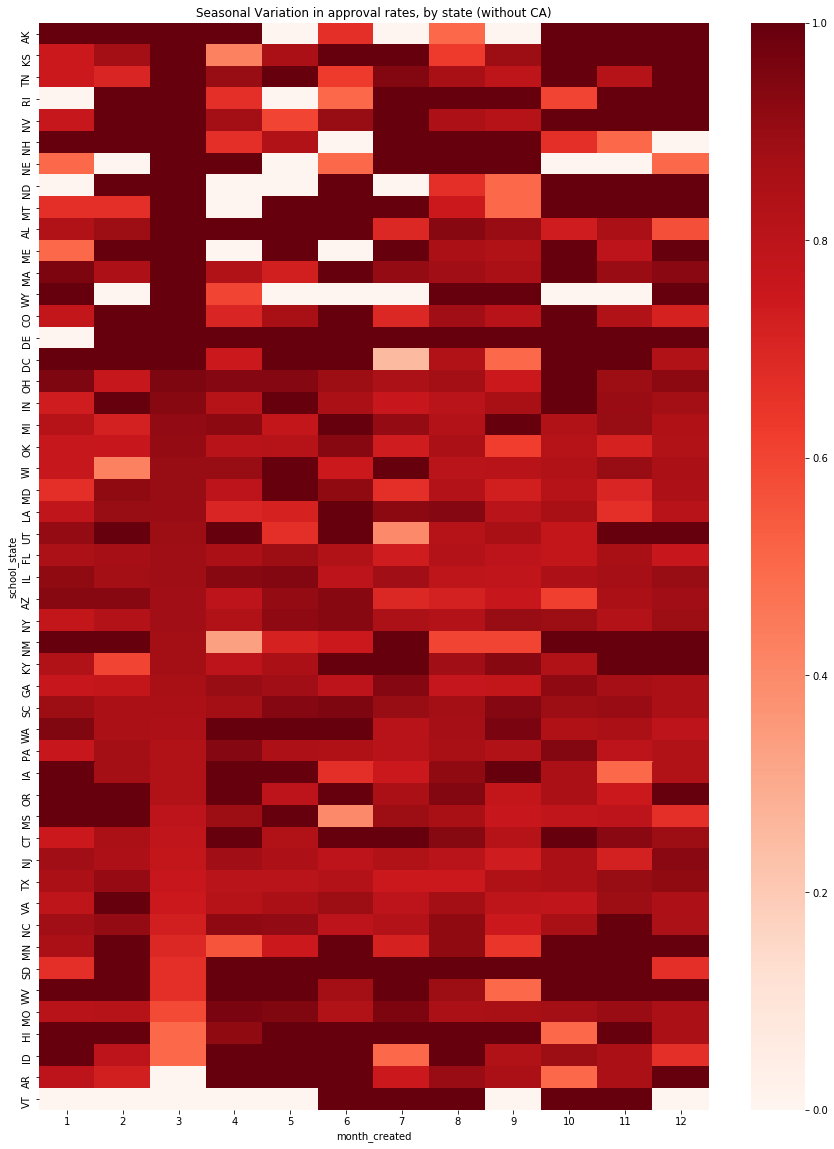

In [90]:
train["project_submitted_datetime"] = pd.to_datetime(train["project_submitted_datetime"])
train["month_created"] = train["project_submitted_datetime"].dt.month
train["year_created"] = train["project_submitted_datetime"].dt.year
loan = train.groupby(['school_state', 'month_created'])['project_is_approved'].mean().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in approval rates, by state (without CA)')
plt.show()

In [91]:
train

,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,...,id,unique_items,total_quantity,mean_cost,total_cost,median_cost,most_exp_cost,least_exp_cost,month_created,year_created
36501,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,...,p036502,2,6,449.970000,899.94,449.970,449.97,449.97,11,2016
39564,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,...,p039565,1,20,400.000000,400.00,400.000,400.00,400.00,4,2017
233822,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,...,p233823,1,1,469.990000,469.99,469.990,469.99,469.99,1,2017
185306,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",...,p185307,5,5,136.894000,684.47,126.870,354.99,18.95,8,2016
13779,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,...,p013780,1,2,711.000000,711.00,711.000,711.00,711.00,8,2016
63373,403c6783e9286e51ab318fba40f8d729,Mrs.,DE,2016-11-05 10:01:51,Grades PreK-2,"Applied Learning, Literacy & Language","Character Education, Literature & Writing",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,...,p063374,2,7,363.680000,727.36,363.680,415.60,311.76,11,2016
103284,4e156c5fb3eea2531601c8736f3751a7,Mrs.,MO,2016-08-31 00:30:43,Grades PreK-2,Health & Sports,Health & Wellness,Active Kindergartners,Kindergarten is the new first grade. My studen...,With balance discs and stools as flexible seat...,...,p103285,2,6,207.010000,414.02,207.010,384.04,29.98,8,2016
181780,c71f2ef13b4bc91afac61ca8fd4c0f9f,Mrs.,SC,2016-08-03 13:26:01,Grades PreK-2,"Applied Learning, Literacy & Language","Early Development, Literature & Writing",Fabulous Firsties-Wiggling to Learn!,First graders are fantastic! They are excited ...,First graders love learning! We need 6 wiggle-...,...,p181781,1,6,414.780000,414.78,414.780,414.78,414.78,8,2016
114988,b580c11b1497a0a67317763b7f03eb27,Ms.,IN,2016-09-13 22:35:57,Grades 6-8,Math & Science,Mathematics,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,...,p114989,1,4,319.800000,319.80,319.800,319.80,319.80,9,2016
191409,2071fb0af994f8f16e7c6ed0f35062a1,Mrs.,IL,2016-09-24 18:38:59,Grades PreK-2,Literacy & Language,Literacy,Snuggle Up With A Good Book,I teach first grade in a small farming town in...,There is nothing better than snuggling up with...,...,p191410,1,2,119.760000,119.76,119.760,119.76,119.76,9,2016


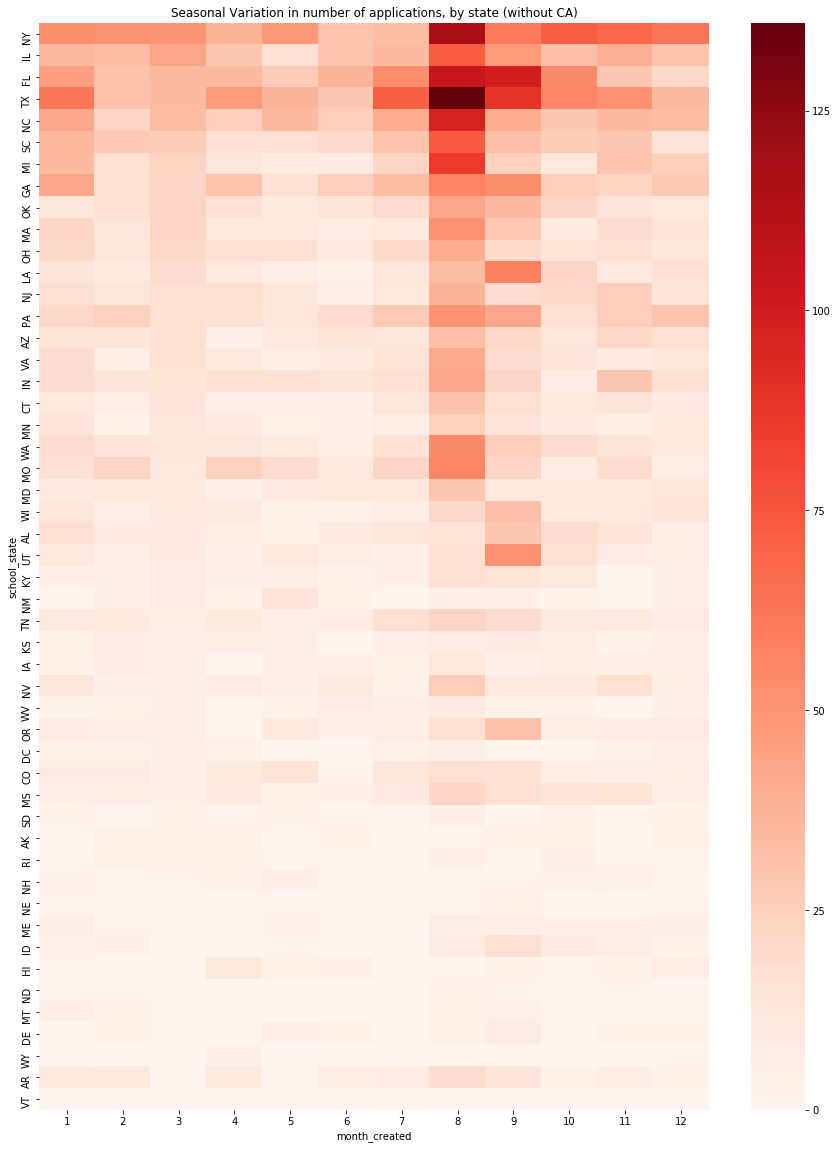

In [92]:
loan = train.groupby(['school_state', 'month_created'])['total_cost'].count().unstack()
loan = loan.sort_values([3], ascending=False)
f, ax = plt.subplots(figsize=(15, 20)) 
loan = loan.fillna(0)
loan = loan.drop('CA',axis=0)
temp = sns.heatmap(loan, cmap='Reds')
plt.title('Seasonal Variation in number of applications, by state (without CA)')
plt.show()

In [93]:
del train['month_created'], train['year_created']

In [94]:
#gen_mon = train.groupby(['datetime_month','gender'])['project_is_approved'].mean().reset_index()
#prev_mon = train.groupby('teacher_number_of_previously_posted_projects')['project_is_approved'].mean().reset_index()

#bins = pd.cut(train['teacher_number_of_previously_posted_projects'], [0, 25, 50, 75, 100, 125, 150])
#pros = train.groupby(bins)['project_is_approved'].agg('mean')

In [95]:
#sns.barplot(pros.index,pros)
#plt.title('Frequent Applicants')
#plt.xlabel("Teacher's Previous Postings")
#plt.ylabel("Mean Approvals")

In [96]:
#train.project_is_approved.value_counts()

In [97]:
#sns.lmplot(x="datetime_month", y="project_is_approved", hue="gender", 
#           data=gen_mon[gen_mon['gender']!='Unk'], 
#           order=3,ci=80)
#plt.title('Approval rate, by month, by gender (ci:90)')

In [98]:
#del gen_mon
#del prev_mon

In [99]:
gc.collect()

18190

#### Cat Preprocessing

There are 51 States, because of 50 + DC

In [100]:
train.isnull().sum()[train.isnull().sum()>0]

project_essay_3    9648
project_essay_4    9648
dtype: int64

In [101]:
train.teacher_prefix[train.teacher_prefix.isnull()] = 'Teacher'
try: 
    test.teacher_prefix[test.teacher_prefix.isnull()] = 'Teacher'
except:
    pass

/Users/Nahel/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


fill na did not work

In [102]:
def date_prep(train):
    train['project_submitted_datetime'] = pd.to_datetime(train['project_submitted_datetime'])
    train['datetime_year'] = train['project_submitted_datetime'].dt.year
    train['datetime_month'] = train['project_submitted_datetime'].dt.month
    return(train)
def gender_features(train):
    conditions = [(train.teacher_prefix == 'Mr.'), 
                  (train.teacher_prefix == 'Mrs.') | (train.teacher_prefix == 'Ms.')]
    choices = ['Male', 'Female']
    train['gender'] = np.select(conditions, choices, default='Unk')
    return(train)

In [103]:
date_prep(train)
if kaggle: date_prep(test)
del date_prep

In [104]:
train = gender_features(train)
if kaggle: 
    test = gender_features(test)
    del test['project_submitted_datetime'], test['project_subject_subcategories']

del train['project_submitted_datetime'], train['project_subject_subcategories']
del gender_features

In [105]:
gc.collect()

38

##### Encoding labels

In [106]:
# Because of trees do no need onehot encoding, label encoding is used
cols  = ['gender',
        'teacher_prefix', 
        'school_state',
        'datetime_year',
        'datetime_month',
        'project_grade_category']

for c in tqdm_notebook(cols):
    encod = LabelEncoder()
    encod.fit(train[c].astype(str))
    train[c] = encod.transform(train[c].astype(str))
    del train[c]
    if kaggle:        
        test[c] = encod.transform(test[c].astype(str))
        del test[c]

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [107]:
train

,teacher_id,project_subject_categories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,id,unique_items,total_quantity,mean_cost,total_cost,median_cost,most_exp_cost,least_exp_cost
36501,484aaf11257089a66cfedc9461c6bd0a,Literacy & Language,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,p036502,2,6,449.970000,899.94,449.970,449.97,449.97
39564,df72a3ba8089423fa8a94be88060f6ed,"Music & The Arts, Health & Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,p039565,1,20,400.000000,400.00,400.000,400.00,400.00
233822,a9b876a9252e08a55e3d894150f75ba3,"Math & Science, Literacy & Language",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,p233823,1,1,469.990000,469.99,469.990,469.99,469.99
185306,525fdbb6ec7f538a48beebaa0a51b24f,Health & Sports,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,p185307,5,5,136.894000,684.47,126.870,354.99,18.95
13779,a63b5547a7239eae4c1872670848e61a,Health & Sports,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,p013780,1,2,711.000000,711.00,711.000,711.00,711.00
63373,403c6783e9286e51ab318fba40f8d729,"Applied Learning, Literacy & Language",Need to Reach Our Virtual Mentors!!!,My kids tell me each day that they want to mak...,I started a program called Telementoring in ho...,NaN,NaN,My students need tablets in order to communic...,0,1,p063374,2,7,363.680000,727.36,363.680,415.60,311.76
103284,4e156c5fb3eea2531601c8736f3751a7,Health & Sports,Active Kindergartners,Kindergarten is the new first grade. My studen...,With balance discs and stools as flexible seat...,NaN,NaN,My students need stability stools and inflatab...,1,1,p103285,2,6,207.010000,414.02,207.010,384.04,29.98
181780,c71f2ef13b4bc91afac61ca8fd4c0f9f,"Applied Learning, Literacy & Language",Fabulous Firsties-Wiggling to Learn!,First graders are fantastic! They are excited ...,First graders love learning! We need 6 wiggle-...,NaN,NaN,My students need wiggle stools to allow them t...,0,1,p181781,1,6,414.780000,414.78,414.780,414.78,414.78
114988,b580c11b1497a0a67317763b7f03eb27,Math & Science,Wobble Chairs Help Fidgety Kids Focus,My seventh graders dream big. They can't wait ...,I have used alternative seating in my classroo...,NaN,NaN,My students need seating that allows the most ...,13,1,p114989,1,4,319.800000,319.80,319.800,319.80,319.80
191409,2071fb0af994f8f16e7c6ed0f35062a1,Literacy & Language,Snuggle Up With A Good Book,I teach first grade in a small farming town in...,There is nothing better than snuggling up with...,NaN,NaN,My students need 2 youth sized reclining chair...,12,1,p191410,1,2,119.760000,119.76,119.760,119.76,119.76


#### Num Preprocessing

In [108]:
num_features  = ['teacher_number_of_previously_posted_projects',
                 'total_quantity', 'mean_cost', 'total_cost','unique_items']

In [109]:
SS = StandardScaler()
train[num_features] = SS.fit_transform(train[num_features])
if kaggle: test[num_features] = SS.transform(test[num_features])

In [110]:
del num_features, StandardScaler, SS

In [111]:
gc.collect()

95

#### Text Preprocessing

In [112]:
other_stopwords = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in ['student','students','education',]:
    other_stopwords.append(j)

In [113]:
#import gensim
from nltk.corpus import stopwords
def scrub(text):
    text = text.strip().lower()
    text = re.sub('\W+',' ', text)    
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\:', ' ', text)
    text = re.sub(r'\+', ' ', text)
    text = re.sub(r'\=', ' ', text)
    text = re.sub(r'(\")', ' ', text)
    text = re.sub(r'(\r)', ' ', text)
    text = re.sub(r'(\n)', ' ', text)
    text = re.sub(r'(\\)', ' ', text)
    text = re.sub('n t ','n\'t ', text)
    text = re.sub(' re ',' are ', text)
    text = re.sub(r'(\r\n)', ' ', text)
    text = re.sub(r'\"\"\"\"', ' ', text)
    text = re.sub(' i m ',' i\'m ', text)
    return(text)
def swords(text):
    text = ' '.join([word for word in text.split() if word not in (other_stopwords)])
    #removed  + stopwords.words("english") because added stopwords to tfidf
    return(text)

##### Project Category Preprocessing

In [114]:
def yup(text):
    text =[word for word in text.split(',')]
    text =[word.strip() for word in text]
    return(text)

In [115]:
yar = train.project_subject_categories.apply(lambda x:yup(x))
p = pd.get_dummies(yar.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
del p['Warmth']

In [116]:
k = p.join(train.reset_index(drop=True).project_is_approved)

In [117]:
k = k.groupby('project_is_approved').sum().transpose()
k['avg'] = k[1]/(k[1] + k[0])
k['count'] = (k[1] + k[0])

In [118]:
k['percent_of_total'] = k['count']/len(train)

In [119]:
k = k.sort_values('percent_of_total',ascending=False)

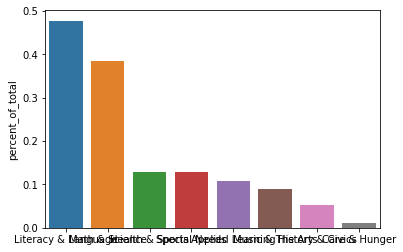

In [120]:
sns.barplot(k.index,k.percent_of_total)

In [121]:
train = train.reset_index(drop=True)
train = train.merge(p,left_index=True,right_index=True)

In [122]:
if kaggle:
    yar = test.project_subject_categories.apply(lambda x:yup(x))
    p = pd.get_dummies(yar.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
    del p['Warmth']
    test = test.reset_index(drop=True)
    test = test.merge(p,left_index=True,right_index=True)
    del test['project_subject_categories']

In [123]:
del train['project_subject_categories'], p, yar

##### Essay Preprocessing

  
#### Before May 17th, 2016:

- project_essay_1: "Introduce us to your classroom"
- project_essay_2: "Tell us more about your students"
- project_essay_3: "Describe how your students will use the materials you're requesting"
- project_essay_4: "Close by sharing why your project will make a difference"

#### May 17th, 2016 and beyond:

- project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

#### Plan
- Combine essay_1 and essay_2 before May 17th to make "student_description" and use essay_1 after May 17th directly
- Combine essay_3 and essay_4 before May 17th to make "project_description" and use essay_2 after May 17th directly

In [124]:
def essay_convert(train):
    # Making the First essay : student_description
    train['student_description']=train['project_essay_1']
    train.loc[train.project_essay_3.notnull(),'student_description']=train.loc[train.project_essay_3.notnull(),'project_essay_1']+train.loc[train.project_essay_3.notnull(),'project_essay_2']

    # Making the second essay : project_description
    train['project_description']=train['project_essay_2']
    train.loc[train.project_essay_3.notnull(),'project_description']=train.loc[train.project_essay_3.notnull(),'project_essay_3']+train.loc[train.project_essay_3.notnull(),'project_essay_4']

    # Removing original essays
    del train['project_essay_1']
    del train['project_essay_2']
    del train['project_essay_3']
    del train['project_essay_4']
    return(train)

In [125]:
essay_convert(train)
if kaggle: essay_convert(test)
gc.collect()

del essay_convert

##### Scrub Text Features

In [126]:
text_features = ['project_title', 'project_resource_summary',
                'project_description', 'student_description']

In [127]:
for j in tqdm_notebook(text_features):
    n_col = 'processed_'+j
    train[n_col] = train[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))
    if kaggle: test[n_col] = test[j].apply(lambda x: scrub(x)).apply(lambda x: swords(x))

gc.collect()
for i in text_features:
    del train[i]
    if kaggle: del test[i]

del stopwords, other_stopwords, text_features, swords

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

In [128]:
gc.collect()

28

In [129]:
train

,teacher_id,teacher_number_of_previously_posted_projects,project_is_approved,id,unique_items,total_quantity,mean_cost,total_cost,median_cost,most_exp_cost,...,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs,processed_project_title,processed_project_resource_summary,processed_project_description,processed_student_description
0,484aaf11257089a66cfedc9461c6bd0a,0.487528,1,p036502,-0.485194,-0.435681,0.517864,0.700796,449.970,449.97,...,0,0,1,0,0,0,super sight word centers,my need 6 ipod nano to create and differentiat...,currently have differentiated sight word cente...,most of my kindergarten come from low income h...
1,df72a3ba8089423fa8a94be88060f6ed,-0.368782,0,p039565,-0.612126,0.135501,0.386748,-0.265381,400.000,400.00,...,1,0,0,0,1,0,keep calm and dance on,my need matching shirts to wear for dance perf...,we strive to provide our diverse population of...,our elementary school is culturally rich schoo...
2,a9b876a9252e08a55e3d894150f75ba3,-0.231772,1,p233823,-0.612126,-0.639674,0.570394,-0.130120,469.990,469.99,...,0,0,1,1,0,0,lets 3doodle to learn,my need the 3doodler we are an sem school whic...,we are looking to add some 3doodler to our cla...,hello nmy name is mrs brotherton teach 5th gra...
3,525fdbb6ec7f538a48beebaa0a51b24f,0.145004,0,p185307,-0.104401,-0.476479,-0.303616,0.284381,126.870,354.99,...,1,0,0,0,0,0,kid inspired equipment to increase activities ...,my need balls and other activity equipment to ...,the project which is totally kid inspired deci...,my are the greatest but are socially and econo...
4,a63b5547a7239eae4c1872670848e61a,1.035566,1,p013780,-0.612126,-0.598875,1.202780,0.335653,711.000,711.00,...,1,0,0,0,0,0,we need clean water for our culinary arts class,my need water filtration system for our culina...,for some reason in our kitchen the water comes...,my are athletes and who are interested in heal...
5,403c6783e9286e51ab318fba40f8d729,-0.403034,1,p063374,-0.485194,-0.394882,0.291448,0.367270,363.680,415.60,...,0,0,1,0,0,0,need to reach our virtual mentors,my need tablets in order to communicate with t...,started program called telementoring in hopes ...,my kids tell me each day that they want to mak...
6,4e156c5fb3eea2531601c8736f3751a7,-0.368782,1,p103285,-0.485194,-0.435681,-0.119639,-0.238287,207.010,384.04,...,1,0,0,0,0,0,active kindergartners,my need stability stools and inflatable discs ...,with balance discs and stools as flexible seat...,kindergarten is the new first grade my are hel...
7,c71f2ef13b4bc91afac61ca8fd4c0f9f,-0.403034,1,p181781,-0.612126,-0.435681,0.425529,-0.236818,414.780,414.78,...,0,0,1,0,0,0,fabulous firsties wiggling to learn,my need wiggle stools to allow them to be acti...,first graders love learning we need 6 wiggle s...,first graders are fantastic they are excited t...
8,b580c11b1497a0a67317763b7f03eb27,0.042247,1,p114989,-0.612126,-0.517278,0.176311,-0.420375,319.800,319.80,...,0,0,0,1,0,0,wobble chairs help fidgety kids focus,my need seating that allows the most fidgety o...,have used alternative seating in my classroom ...,my seventh graders dream big they can't wait t...
9,2071fb0af994f8f16e7c6ed0f35062a1,0.007995,1,p191410,-0.612126,-0.598875,-0.348574,-0.806969,119.760,119.76,...,0,0,1,0,0,0,snuggle up with good book,my need 2 youth sized reclining chairs for rea...,there is nothing better than snuggling up with...,teach first grade in small farming town in ill...


## Word Clouds?

In [ ]:
train.project_is_approved

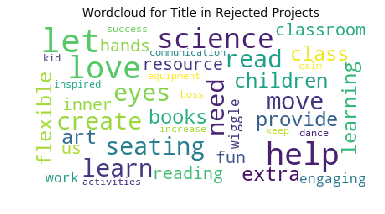

In [160]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==0].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title('Wordcloud for Title in Rejected Projects')
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

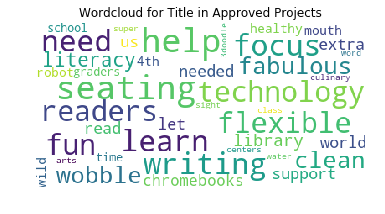

In [161]:
wordcloud = WordCloud(
                          background_color='white',
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(train[train.project_is_approved==1].processed_project_title))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud for Title in Approved Projects')
plt.show()
fig.savefig("word1.png", dpi=900);

## Modeling

### Tfidf & X,y Assignment

In [38]:
gc.collect()

118

In [39]:
cols = [
    'processed_project_title',
    'processed_project_resource_summary', 
    'processed_project_description',
    'processed_student_description']

In [40]:
for i in cols:
    print("Average length in {} is {} words".format(i,str(round(train[i].str.len().mean()))))

Average length in processed_project_title is 30 words
Average length in processed_project_resource_summary is 108 words
Average length in processed_project_description is 779 words
Average length in processed_student_description is 614 words


In [41]:
n_features = [
    100, 
    200, 
    1000,
    1000]

In [46]:
train

,teacher_id,teacher_number_of_previously_posted_projects,project_is_approved,id,unique_items,total_quantity,mean_cost,total_cost,median_cost,most_exp_cost,...,processed_student_description_tfidf_working,processed_student_description_tfidf_works,processed_student_description_tfidf_world,processed_student_description_tfidf_write,processed_student_description_tfidf_writers,processed_student_description_tfidf_writing,processed_student_description_tfidf_year,processed_student_description_tfidf_years,processed_student_description_tfidf_york,processed_student_description_tfidf_young
0,484aaf11257089a66cfedc9461c6bd0a,0.487528,1,p036502,-0.485194,-0.435681,0.517864,0.700796,449.970,449.97,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.226440,0.000000,0.0,0.000000
1,df72a3ba8089423fa8a94be88060f6ed,-0.368782,0,p039565,-0.612126,0.135501,0.386748,-0.265381,400.000,400.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,a9b876a9252e08a55e3d894150f75ba3,-0.231772,1,p233823,-0.612126,-0.639674,0.570394,-0.130120,469.990,469.99,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113220,0.0,0.000000
3,525fdbb6ec7f538a48beebaa0a51b24f,0.145004,0,p185307,-0.104401,-0.476479,-0.303616,0.284381,126.870,354.99,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045959,0.000000,0.0,0.000000
4,a63b5547a7239eae4c1872670848e61a,1.035566,1,p013780,-0.612126,-0.598875,1.202780,0.335653,711.000,711.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5,403c6783e9286e51ab318fba40f8d729,-0.403034,1,p063374,-0.485194,-0.394882,0.291448,0.367270,363.680,415.60,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109375,0.000000,0.0,0.000000
6,4e156c5fb3eea2531601c8736f3751a7,-0.368782,1,p103285,-0.485194,-0.435681,-0.119639,-0.238287,207.010,384.04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.150879
7,c71f2ef13b4bc91afac61ca8fd4c0f9f,-0.403034,1,p181781,-0.612126,-0.435681,0.425529,-0.236818,414.780,414.78,...,0.000000,0.000000,0.153564,0.000000,0.000000,0.000000,0.134277,0.000000,0.0,0.000000
8,b580c11b1497a0a67317763b7f03eb27,0.042247,1,p114989,-0.612126,-0.517278,0.176311,-0.420375,319.800,319.80,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,2071fb0af994f8f16e7c6ed0f35062a1,0.007995,1,p191410,-0.612126,-0.598875,-0.348574,-0.806969,119.760,119.76,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [43]:
gc.collect()

59

In [45]:
for c_i, c in tqdm_notebook(enumerate(cols)):
    tfidf = TfidfVectorizer(
        stop_words='english',
        ngram_range=(1,4),
        max_features=n_features[c_i])

    tfidf.fit(train[c])

    tfidf_train = np.array(tfidf.transform(train[c].values).toarray(), dtype=np.float16)
    for i in range(n_features[c_i]):
        train[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_train[:, i]
    if kaggle:
        tfidf_test = np.array(tfidf.transform(test[c].values).toarray(), dtype=np.float16)
        for i in range(n_features[c_i]):
            test[c + '_contains_-' + tfidf.get_feature_names()[i]] = tfidf_test[:, i]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/Nahel/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/Nahel/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/Nahel/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [50]:
for i in cols:
    del train[i]
    if kaggle: del test[i]

if kaggle: del tfidf_test
del tfidf_train, tfidf

NameError: name 'train' is not defined

In [47]:
drop_cols = ['project_is_approved','id','teacher_id']

X = train.drop(drop_cols, axis=1)
y = train['project_is_approved']
feature_names = list(X.columns)
del train

In [ ]:
#if running demo, uncomment this and change test['id'].vaues -> test['index'].values
test = test.reset_index(drop=True)

In [ ]:
X_kaggle = test.drop(drop_cols, axis=1, errors='ignore')
id_test = test['id'].values

In [ ]:
del X_kaggle['level_0']

In [ ]:
X_kaggle.columns.shape

In [ ]:
X.columns.shape

### Grid Search over LGBM for best params without training

In [48]:
model = lgb.LGBMClassifier(
    boosting_type="gbdt",
    is_unbalance=True, 
    random_state=10,
    bagging_freq=5,
    learning_rate=0.025,
    objective= 'binary', 
    metric= 'auc',
    min_child_samples=5,
    verbose=1,
    n_jobs=-1)

In [ ]:
params_opt = {'num_leaves': [x for x in range(20,31,1)],
            'max_depth': [x for x in range(15,21)],
            'feature_fraction': [x / 1000.0 for x in range(825,900,25)],
            'bagging_fraction': [x / 1000.0 for x in range(825,900,25)],
            'lambda_l2' : [x / 100.0 for x in range(0,110,10)],}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rs = RandomizedSearchCV(
    model, 
    params_opt, 
    n_iter=5,
    scoring='roc_auc',
    verbose=5,
    cv=4,
    n_jobs=-1)

rs.fit(X,y)

In [ ]:
rs.best_score_

In [ ]:
rs.best_params_

In [ ]:
train.head()

### Training Best LGBM

In [75]:
# Build the model
cnt = 0
n_splits = 5
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=42)

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    
    params = {'is_unbalance': True, 
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.025,
        'bagging_freq': 5,
        'verbose': 1,
        'min_gain_to_split': 3,
        'min_child_samples' : 5,

        'num_threads': 1,
        'lambda_l2': 0.08,              
        'bagging_fraction': 0.85,
        'feature_fraction': 0.85,
        'max_depth': 18,
        'num_leaves': 24,
    }  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names)

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index])

    model = lgb.train(
        params, lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=1,
        verbose_eval=10,)

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
    
    cnt = cnt+1

Fold 1/5
Training until validation scores don't improve for 1 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.795625	valid_1's auc: 0.684995
Important features:
('teacher_number_of_previously_posted_projects', 9)
('unique_items', 8)
('processed_project_description_tfidf_books', 5)
('least_exp_cost', 5)
('processed_project_description_tfidf_story', 4)
('processed_project_description_tfidf_markers', 4)
('processed_project_description_tfidf_folders', 4)
('processed_project_resource_summary_tfidf_need', 4)
('processed_student_description_tfidf_expectations', 3)
('processed_project_description_tfidf_use', 3)
('processed_project_description_tfidf_school', 3)
('processed_project_description_tfidf_mats', 3)
('processed_project_description_tfidf_magnetic', 3)
('median_cost', 3)
('processed_student_description_tfidf_sensory', 2)
('processed_student_description_tfidf_classroom', 2)
('processed_project_description_tfidf_want', 2)
('processed_project_description_tfidf_sit', 2)
('pr

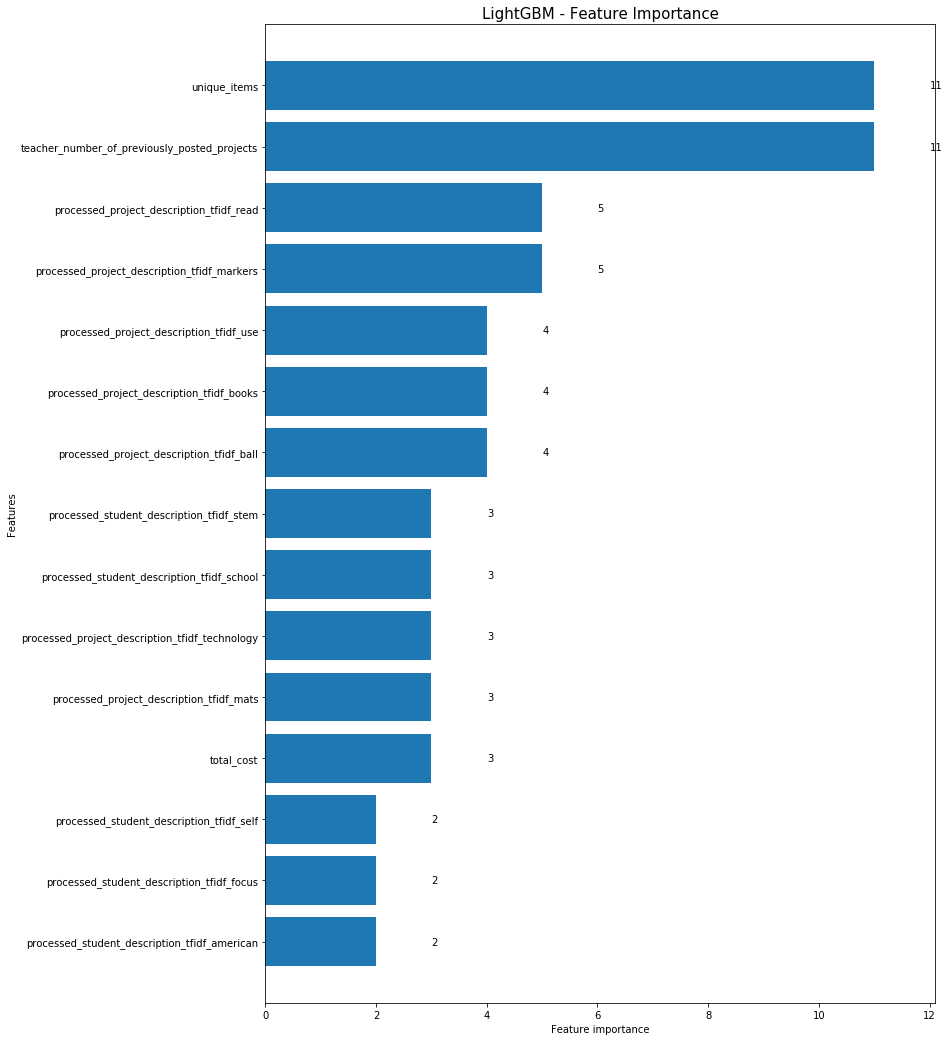

In [77]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=15, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
p = model.predict(X_kaggle, num_iteration=model.best_iteration)

In [ ]:
submit = pd.DataFrame({'id':id_test,'pred':p})

In [ ]:
submit

In [ ]:
#submit.sort_values('pred',axis=0,)